In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import defaultdict

# Load dataset
df = pd.read_csv("E:\downloads\data_final(in) (1).csv")

c:\Users\21629\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
def parse_labels(label_string):
    paths = label_string.split('@')
    parsed_paths = ["/".join(path.split('/')) for path in paths]
    return parsed_paths

df['ParsedLabels'] = df['Label'].apply(parse_labels)

In [5]:
# Verify Label Parsing
print("Verifying Label Parsing:")
for i in range(5):
    print(f"Original: {df['Label'][i]}")
    print(f"Parsed: {df['ParsedLabels'][i]}")
    print("---")

Verifying Label Parsing:
Original: data/manipulation/filter
Parsed: ['data/manipulation/filter']
---
Original: reliability/error-handling/exceptions
Parsed: ['reliability/error-handling/exceptions']
---
Original: interface/button
Parsed: ['interface/button']
---
Original: interface/button/clickbehavior
Parsed: ['interface/button/clickbehavior']
---
Original: data/manipulation/sort
Parsed: ['data/manipulation/sort']
---


In [6]:
mlb = MultiLabelBinarizer()
flat_labels = mlb.fit_transform(df['ParsedLabels'])

In [8]:
def process_text(text):
    tokens = word_tokenize(text.lower())
    resulting_words = []
    lemmatizer = WordNetLemmatizer()
    english_stopwords = stopwords.words('english')
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    for word, tag in pos_tag(tokens):
        if word.isalpha() and word not in english_stopwords:
            resulting_words.append(lemmatizer.lemmatize(word, tag_map[tag[0]]))

    return ' '.join(resulting_words)

# Apply text preprocessing
df['Summary'] = df['Issue'].apply(process_text)

# Handle missing values in 'Summary'
df['Summary'].fillna('', inplace=True)

In [9]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_matrix = vectorizer.fit_transform(df['Summary'])

In [10]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = sentence_model.encode(df['Summary'].tolist())

In [11]:
tfidf_dense = tfidf_matrix.toarray()
pca = PCA()
pca.fit(tfidf_dense)
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

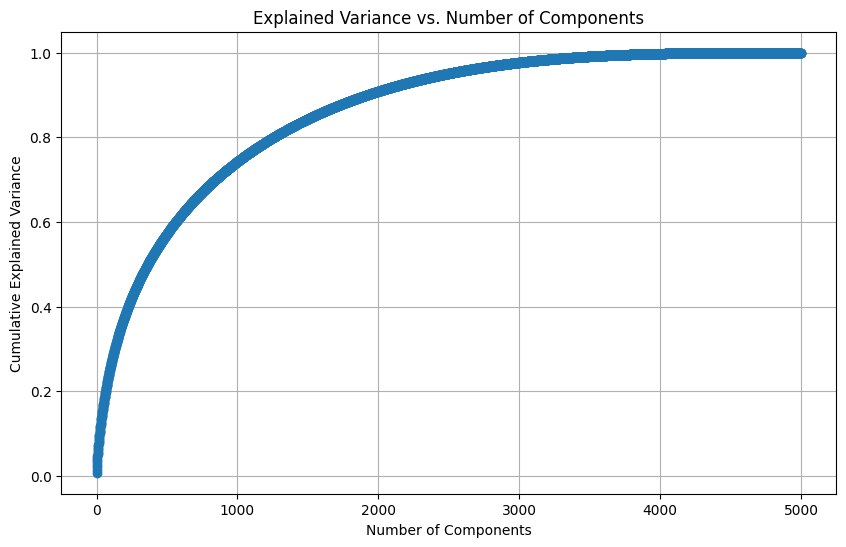

Number of components needed to explain 95.0% variance: 2485


In [ ]:
# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Optionally, you can print the number of components needed to explain a certain percentage of variance
explained_variance_threshold = 0.95  
num_components = np.argmax(cumulative_explained_variance >= explained_variance_threshold) + 1
print(f'Number of components needed to explain {explained_variance_threshold * 100}% variance: {num_components}')

In [13]:
pca = PCA(n_components=2485)
reduced_tfidf_matrix = pca.fit_transform(tfidf_matrix.toarray())

In [14]:
combined_features = np.hstack((reduced_tfidf_matrix, sentence_embeddings))

In [15]:

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 50]
}


clf = RandomForestClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy')
grid_search.fit(combined_features, flat_labels)

best_clf = grid_search.best_estimator_
selector = SelectFromModel(best_clf, prefit=True)
selected_features = selector.transform(combined_features)

In [ ]:

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
# Verify Selected Features
print("Verifying Selected Features:")
# Evaluate with all features
clf.fit(combined_features, flat_labels)
all_features_score = clf.score(combined_features, flat_labels)
print(f"Accuracy with all features: {all_features_score}")

# Evaluate with selected features
clf.fit(selected_features, flat_labels)
selected_features_score = clf.score(selected_features, flat_labels)
print(f"Accuracy with selected features: {selected_features_score}")

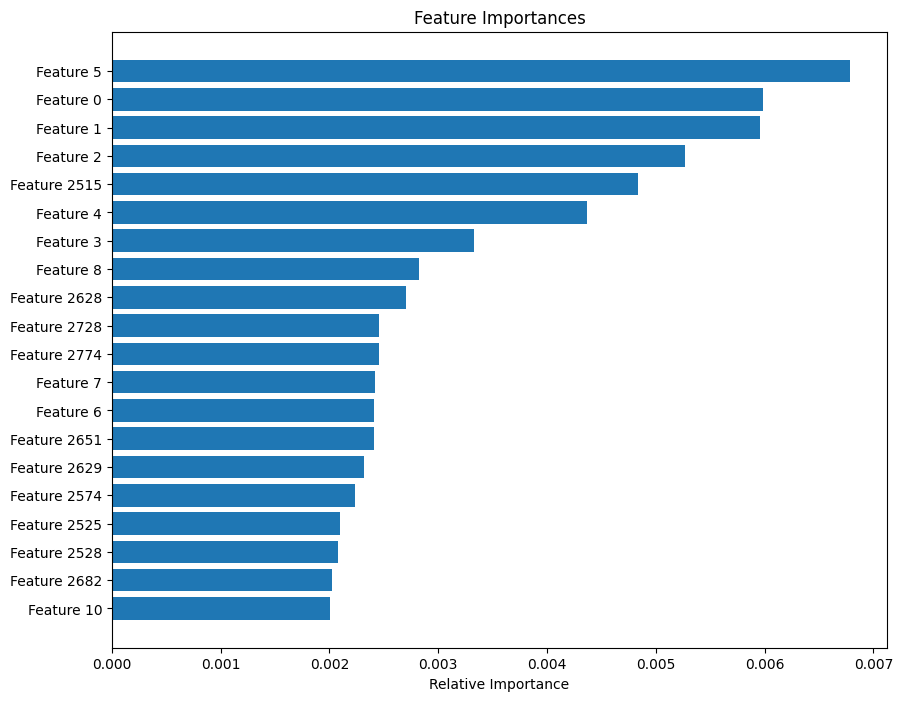

In [17]:
importances = best_clf.feature_importances_
indices = np.argsort(importances)[-20:]  # Top 20 features

plt.figure(figsize=(10, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [f'Feature {i}' for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [18]:
# Save the selected features for hierarchical classification
selected_df = pd.DataFrame(selected_features)
selected_df['Label'] = df['Label']
selected_df.to_csv('C:/Users/21629/Desktop/selected_features_bugs_aug.csv', index=False)

In [19]:
with open('C:/Users/21629/Desktop/tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

with open('C:/Users/21629/Desktop/pca_transformer.pkl', 'wb') as file:
    pickle.dump(pca, file)

with open('C:/Users/21629/Desktop/feature_selector.pkl', 'wb') as file:
    pickle.dump(selector, file)

sentence_model.save('C:/Users/21629/Desktop/sentence_transformer_model/')